# Cryptocurrency Price Prediction

This notebook implements a LightGBM-based machine learning model for predicting cryptocurrency price movements using extensive feature engineering.

## Overview

- **Model**: LightGBM (Gradient Boosting)
- **Features**: 500+ engineered features from OHLCV data
- **Target Metric**: Pearson Correlation > 0.10

## Table of Contents
1. [Setup and Imports](#1.-Setup-and-Imports)
2. [Data Loading](#2.-Data-Loading)
3. [Feature Engineering](#3.-Feature-Engineering)
4. [Data Preprocessing](#4.-Data-Preprocessing)
5. [Model Training](#5.-Model-Training)
6. [Model Evaluation](#6.-Model-Evaluation)
7. [Generate Submission](#7.-Generate-Submission)

---
## 1. Setup and Imports

Import all necessary libraries for data processing, modeling, and visualization.

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import pickle
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

print("=" * 60)
print("Cryptocurrency Price Prediction - Ultra Advanced Model")
print("=" * 60)

Cryptocurrency Price Prediction - Ultra Advanced Model


---
## 2. Data Loading

Load the training and test datasets. The data contains OHLCV (Open, High, Low, Close, Volume) information with timestamps.

In [2]:
print("Loading data...")
train = pd.read_csv('input/train.csv', parse_dates=['Timestamp'])
test = pd.read_csv('input/test.csv', parse_dates=['Timestamp'])

print(f"Train shape: {train.shape}")
print(f"Test shape: {test.shape}")

Loading data...
Train shape: (484202, 7)
Test shape: (2881, 6)


In [3]:
# Preview the training data
print("Training data preview:")
train.head()

Training data preview:


,Timestamp,Open,High,Low,Close,Volume,Target
0,2012-01-01 10:00:00,4.58,4.58,4.58,4.58,0.0,0.0
1,2012-01-01 10:15:00,4.58,4.58,4.58,4.58,0.0,0.0
2,2012-01-01 10:30:00,4.58,4.58,4.58,4.58,0.0,0.0
3,2012-01-01 10:45:00,4.58,4.58,4.58,4.58,0.0,0.0
4,2012-01-01 11:00:00,4.58,4.58,4.58,4.58,0.0,0.0


In [4]:
# Check data info
print("Training data info:")
train.info()

Training data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 484202 entries, 0 to 484201
Data columns (total 7 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   Timestamp  484202 non-null  datetime64[ns]
 1   Open       484202 non-null  float64       
 2   High       484202 non-null  float64       
 3   Low        484202 non-null  float64       
 4   Close      484202 non-null  float64       
 5   Volume     484202 non-null  float64       
 6   Target     484202 non-null  float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 25.9 MB


In [5]:
# Statistical summary
print("Training data statistics:")
train.describe()

Training data statistics:


,Timestamp,Open,High,Low,Close,Volume,Target
count,484202,484202.000000,484202.000000,484202.000000,484202.000000,484202.000000,484202.000000
mean,2018-11-27 07:57:43.006141952,20658.013160,20697.816112,20616.371899,20658.196823,77.300625,0.000021
min,2012-01-01 10:00:00,4.140000,4.140000,3.800000,4.140000,0.000000,-0.276799
25%,2015-06-15 08:33:45,439.990000,441.000000,438.430000,440.000000,7.580896,-0.001275
50%,2018-11-27 07:07:30,7183.130000,7199.000000,7165.760000,7182.745000,26.952946,0.000000
75%,2022-05-11 05:41:15,30169.955000,30214.720000,30115.120000,30169.750000,77.183091,0.001384
max,2025-10-23 23:15:00,126094.000000,126272.000000,125675.000000,126111.000000,11166.690839,0.598299
std,NaN,29232.444299,29278.365259,29185.082799,29232.673493,176.809316,0.005454


---
## 3. Feature Engineering

This is the core of our approach. We create 500+ features from the raw OHLCV data, including:

### Feature Categories:
1. **Price Features**: Returns, ranges, candlestick patterns
2. **Lag Features**: Historical values at various time lags
3. **Rolling Statistics**: Mean, std, skew, kurtosis over multiple windows
4. **Volatility Features**: Realized vol, Parkinson, Garman-Klass, ATR
5. **Technical Indicators**: MACD, RSI, Bollinger Bands, Stochastics, etc.
6. **Volume Features**: OBV, VPT, relative volume
7. **Momentum Features**: Momentum, ROC, trend strength
8. **Mean Reversion**: Z-scores, R/S statistic
9. **Time Features**: Hour, day, session with cyclical encoding
10. **Interaction Features**: Combined signals

In [6]:
def create_ultra_advanced_features(df):
    """Create ultra comprehensive features for cryptocurrency prediction."""
    df = df.copy()

    # ==========================================================================
    # BASIC PRICE FEATURES
    # ==========================================================================
    # Log returns - standard measure with nice statistical properties
    df['returns'] = np.log(df['Close'] / df['Close'].shift(1))
    df['log_volume'] = np.log(df['Volume'] + 1)

    # Price-based features - capture intrabar dynamics
    df['high_low_range'] = (df['High'] - df['Low']) / df['Close']
    df['close_open_range'] = (df['Close'] - df['Open']) / df['Close']
    df['upper_shadow'] = (df['High'] - df[['Open', 'Close']].max(axis=1)) / df['Close']
    df['lower_shadow'] = (df[['Open', 'Close']].min(axis=1) - df['Low']) / df['Close']
    df['body'] = abs(df['Close'] - df['Open']) / df['Close']
    df['is_bullish'] = (df['Close'] > df['Open']).astype(int)

    # Typical price
    df['typical_price'] = (df['High'] + df['Low'] + df['Close']) / 3

    # Log returns from different price points
    df['returns_open'] = np.log(df['Open'] / df['Open'].shift(1))
    df['returns_high'] = np.log(df['High'] / df['High'].shift(1))
    df['returns_low'] = np.log(df['Low'] / df['Low'].shift(1))

    # ==========================================================================
    # LAG FEATURES
    # ==========================================================================
    # Extensive lags to capture autocorrelation patterns
    for lag in [1, 2, 3, 4, 5, 6, 7, 8, 10, 12, 14, 16, 20, 24, 28, 32, 40, 48, 64, 80, 96, 128, 192, 288, 384]:
        df[f'returns_lag_{lag}'] = df['returns'].shift(lag)
        if lag <= 48:
            df[f'volume_lag_{lag}'] = df['log_volume'].shift(lag)
            df[f'range_lag_{lag}'] = df['high_low_range'].shift(lag)

    # ==========================================================================
    # ROLLING STATISTICS
    # ==========================================================================
    for window in [4, 6, 8, 12, 16, 24, 32, 48, 64, 96, 128, 192, 288, 384, 576]:
        df[f'returns_mean_{window}'] = df['returns'].rolling(window).mean()
        df[f'returns_std_{window}'] = df['returns'].rolling(window).std()
        df[f'returns_sum_{window}'] = df['returns'].rolling(window).sum()

        if window <= 128:
            df[f'returns_skew_{window}'] = df['returns'].rolling(window).skew()
            df[f'returns_kurt_{window}'] = df['returns'].rolling(window).kurt()
            df[f'returns_min_{window}'] = df['returns'].rolling(window).min()
            df[f'returns_max_{window}'] = df['returns'].rolling(window).max()
            df[f'returns_median_{window}'] = df['returns'].rolling(window).median()
            df[f'returns_q25_{window}'] = df['returns'].rolling(window).quantile(0.25)
            df[f'returns_q75_{window}'] = df['returns'].rolling(window).quantile(0.75)

            # Volume rolling features
            df[f'volume_mean_{window}'] = df['log_volume'].rolling(window).mean()
            df[f'volume_std_{window}'] = df['log_volume'].rolling(window).std()

            # Range rolling features
            df[f'range_mean_{window}'] = df['high_low_range'].rolling(window).mean()
            df[f'range_std_{window}'] = df['high_low_range'].rolling(window).std()

    # ==========================================================================
    # REALIZED VOLATILITY
    # ==========================================================================
    for window in [4, 8, 12, 16, 24, 32, 48, 64, 96, 128]:
        df[f'realized_vol_{window}'] = np.sqrt((df['returns'] ** 2).rolling(window).sum())
        df[f'realized_vol_norm_{window}'] = df[f'realized_vol_{window}'] / (df['returns'].rolling(window * 4).std() * np.sqrt(window) + 1e-10)

    # ==========================================================================
    # MOVING AVERAGES
    # ==========================================================================
    # Simple Moving Averages
    for window in [4, 6, 8, 12, 16, 24, 32, 48, 64, 96, 128, 192, 288]:
        df[f'close_to_sma_{window}'] = (df['Close'] - df['Close'].rolling(window).mean()) / (df['Close'].rolling(window).mean() + 1e-10)

    # Exponential Moving Averages
    for span in [4, 6, 8, 12, 16, 24, 32, 48, 64, 96, 128]:
        ema = df['Close'].ewm(span=span, adjust=False).mean()
        df[f'close_to_ema_{span}'] = (df['Close'] - ema) / (ema + 1e-10)

    # EMA of returns
    for span in [4, 8, 12, 16, 24, 32, 48]:
        df[f'ema_returns_{span}'] = df['returns'].ewm(span=span, adjust=False).mean()

    # EMA crossovers - trend change detection
    for short, long in [(4, 12), (8, 24), (12, 48), (16, 64), (24, 96), (32, 128)]:
        ema_short = df['Close'].ewm(span=short, adjust=False).mean()
        ema_long = df['Close'].ewm(span=long, adjust=False).mean()
        df[f'ema_cross_{short}_{long}'] = (ema_short - ema_long) / (ema_long + 1e-10)

    # ==========================================================================
    # MACD
    # ==========================================================================
    ema_12 = df['Close'].ewm(span=12, adjust=False).mean()
    ema_26 = df['Close'].ewm(span=26, adjust=False).mean()
    macd = ema_12 - ema_26
    macd_signal = macd.ewm(span=9, adjust=False).mean()
    df['macd_norm'] = macd / df['Close']
    df['macd_hist_norm'] = (macd - macd_signal) / df['Close']
    df['macd_signal_norm'] = macd_signal / df['Close']

    # ==========================================================================
    # RSI (Relative Strength Index)
    # ==========================================================================
    for period in [4, 6, 8, 12, 14, 20, 24, 32, 48]:
        delta = df['Close'].diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
        rs = gain / (loss + 1e-10)
        df[f'rsi_{period}'] = 100 - (100 / (1 + rs))
        df[f'rsi_change_{period}'] = df[f'rsi_{period}'].diff()

    # ==========================================================================
    # BOLLINGER BANDS
    # ==========================================================================
    for window in [16, 20, 32, 48, 64]:
        bb_middle = df['Close'].rolling(window).mean()
        bb_std = df['Close'].rolling(window).std()
        df[f'bb_width_{window}'] = (2 * bb_std) / (bb_middle + 1e-10)
        df[f'bb_position_{window}'] = (df['Close'] - (bb_middle - 2 * bb_std)) / (4 * bb_std + 1e-10)

    # ==========================================================================
    # ATR (Average True Range)
    # ==========================================================================
    for period in [8, 14, 20, 24, 32, 48]:
        high_low = df['High'] - df['Low']
        high_close = abs(df['High'] - df['Close'].shift(1))
        low_close = abs(df['Low'] - df['Close'].shift(1))
        true_range = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
        atr = true_range.rolling(period).mean()
        df[f'atr_norm_{period}'] = atr / df['Close']

    # Volatility regime detection
    natr_14 = df['atr_norm_14']
    df['natr_14_sma'] = natr_14.rolling(48).mean()
    df['vol_regime'] = natr_14 / (df['natr_14_sma'] + 1e-10)
    df['vol_regime_change'] = df['vol_regime'].diff()

    # ==========================================================================
    # MOMENTUM FEATURES
    # ==========================================================================
    for period in [4, 6, 8, 12, 16, 24, 32, 48, 64, 96, 128]:
        df[f'momentum_{period}'] = df['Close'] / df['Close'].shift(period) - 1
        df[f'roc_{period}'] = df['Close'].pct_change(periods=period)
        df[f'momentum_change_{period}'] = df[f'momentum_{period}'].diff()

    # ==========================================================================
    # STOCHASTIC OSCILLATOR
    # ==========================================================================
    for period in [8, 14, 20, 24, 32]:
        low_min = df['Low'].rolling(period).min()
        high_max = df['High'].rolling(period).max()
        df[f'stoch_k_{period}'] = 100 * (df['Close'] - low_min) / (high_max - low_min + 1e-10)
        df[f'stoch_d_{period}'] = df[f'stoch_k_{period}'].rolling(3).mean()
        df[f'stoch_diff_{period}'] = df[f'stoch_k_{period}'] - df[f'stoch_d_{period}']

    # ==========================================================================
    # WILLIAMS %R
    # ==========================================================================
    for period in [8, 14, 24]:
        high_max = df['High'].rolling(period).max()
        low_min = df['Low'].rolling(period).min()
        df[f'williams_r_{period}'] = -100 * (high_max - df['Close']) / (high_max - low_min + 1e-10)

    # ==========================================================================
    # CCI (Commodity Channel Index)
    # ==========================================================================
    for period in [14, 20, 32, 48]:
        tp = df['typical_price']
        sma_tp = tp.rolling(period).mean()
        mad = tp.rolling(period).apply(lambda x: np.abs(x - x.mean()).mean(), raw=True)
        df[f'cci_{period}'] = (tp - sma_tp) / (0.015 * mad + 1e-10)

    # ==========================================================================
    # OBV (On-Balance Volume) FEATURES
    # ==========================================================================
    obv = (np.sign(df['Close'].diff()) * df['Volume']).fillna(0).cumsum()
    df['obv_change'] = obv.diff()
    df['obv_pct_change'] = obv.pct_change()
    for window in [8, 16, 24, 48]:
        obv_sma = obv.rolling(window).mean()
        df[f'obv_to_sma_{window}'] = (obv - obv_sma) / (abs(obv_sma) + 1e-10)

    # ==========================================================================
    # VOLUME FEATURES
    # ==========================================================================
    df['volume_change'] = df['Volume'].pct_change()
    df['volume_price_trend'] = df['Volume'] * df['returns']
    df['volume_price_corr'] = df['returns'].rolling(24).corr(df['log_volume'])
    for window in [8, 16, 24, 48]:
        df[f'vpt_sum_{window}'] = df['volume_price_trend'].rolling(window).sum()

    # Relative volume
    for window in [12, 24, 48, 96]:
        df[f'relative_volume_{window}'] = df['Volume'] / (df['Volume'].rolling(window).mean() + 1e-10)

    # ==========================================================================
    # PRICE ACCELERATION
    # ==========================================================================
    df['returns_diff'] = df['returns'].diff()
    df['returns_diff2'] = df['returns_diff'].diff()

    # ==========================================================================
    # TREND STRENGTH
    # ==========================================================================
    for window in [12, 16, 24, 32, 48, 64, 96, 128]:
        df[f'trend_strength_{window}'] = df['returns'].rolling(window).sum() / (df['returns'].rolling(window).std() * np.sqrt(window) + 1e-10)

    # ==========================================================================
    # VOLATILITY RATIO
    # ==========================================================================
    for short, long in [(4, 16), (4, 24), (4, 48), (8, 32), (8, 48), (8, 64), (16, 64), (24, 96), (32, 128)]:
        df[f'vol_ratio_{short}_{long}'] = df['returns'].rolling(short).std() / (df['returns'].rolling(long).std() + 1e-10)

    # ==========================================================================
    # MEAN REVERSION (Z-SCORES)
    # ==========================================================================
    for window in [12, 16, 24, 32, 48, 64, 96, 128]:
        df[f'zscore_{window}'] = (df['Close'] - df['Close'].rolling(window).mean()) / (df['Close'].rolling(window).std() + 1e-10)
        df[f'zscore_returns_{window}'] = (df['returns'] - df['returns'].rolling(window).mean()) / (df['returns'].rolling(window).std() + 1e-10)

    # ==========================================================================
    # HURST EXPONENT APPROXIMATION (R/S)
    # ==========================================================================
    for window in [24, 48, 96]:
        rs_values = []
        for i in range(len(df)):
            if i < window:
                rs_values.append(np.nan)
            else:
                segment = df['returns'].iloc[i-window:i].dropna()
                if len(segment) > 2:
                    mean = segment.mean()
                    std = segment.std()
                    if std > 0:
                        cumdev = (segment - mean).cumsum()
                        rs = (cumdev.max() - cumdev.min()) / std
                        rs_values.append(rs)
                    else:
                        rs_values.append(np.nan)
                else:
                    rs_values.append(np.nan)
        df[f'rs_{window}'] = rs_values

    # ==========================================================================
    # PARKINSON VOLATILITY
    # ==========================================================================
    for window in [8, 16, 24, 48]:
        df[f'parkinson_vol_{window}'] = np.sqrt(
            (1 / (4 * np.log(2))) * ((np.log(df['High'] / df['Low'])) ** 2).rolling(window).mean()
        )

    # ==========================================================================
    # GARMAN-KLASS VOLATILITY
    # ==========================================================================
    for window in [8, 16, 24, 48]:
        log_hl = np.log(df['High'] / df['Low']) ** 2
        log_co = np.log(df['Close'] / df['Open']) ** 2
        df[f'gk_vol_{window}'] = np.sqrt(
            0.5 * log_hl.rolling(window).mean() - (2 * np.log(2) - 1) * log_co.rolling(window).mean()
        )

    # ==========================================================================
    # PRICE EFFICIENCY RATIO
    # ==========================================================================
    for window in [8, 16, 24, 48, 96]:
        net_change = abs(df['Close'] - df['Close'].shift(window))
        sum_changes = abs(df['Close'].diff()).rolling(window).sum()
        df[f'efficiency_ratio_{window}'] = net_change / (sum_changes + 1e-10)

    # ==========================================================================
    # TIME FEATURES
    # ==========================================================================
    df['hour'] = df['Timestamp'].dt.hour
    df['day_of_week'] = df['Timestamp'].dt.dayofweek
    df['day_of_month'] = df['Timestamp'].dt.day
    df['month'] = df['Timestamp'].dt.month
    df['minute'] = df['Timestamp'].dt.minute
    df['week_of_year'] = df['Timestamp'].dt.isocalendar().week.astype(int)

    # Cyclical encoding for time features
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    df['day_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
    df['day_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    df['minute_sin'] = np.sin(2 * np.pi * df['minute'] / 60)
    df['minute_cos'] = np.cos(2 * np.pi * df['minute'] / 60)

    # Is weekend
    df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)

    # Session features
    df['is_asia_session'] = ((df['hour'] >= 0) & (df['hour'] < 8)).astype(int)
    df['is_europe_session'] = ((df['hour'] >= 8) & (df['hour'] < 16)).astype(int)
    df['is_us_session'] = ((df['hour'] >= 16) & (df['hour'] < 24)).astype(int)

    # Time period returns aggregation
    for period_hours in [1, 2, 4, 6, 12]:
        period_intervals = period_hours * 4  # 15-min intervals
        df[f'returns_sum_{period_hours}h'] = df['returns'].rolling(period_intervals).sum()
        df[f'returns_max_{period_hours}h'] = df['returns'].rolling(period_intervals).max()
        df[f'returns_min_{period_hours}h'] = df['returns'].rolling(period_intervals).min()

    # ==========================================================================
    # INTRADAY FEATURES
    # ==========================================================================
    df['date'] = df['Timestamp'].dt.date
    daily_high = df.groupby('date')['High'].transform('max')
    daily_low = df.groupby('date')['Low'].transform('min')
    daily_open = df.groupby('date')['Open'].transform('first')
    daily_close_prev = df.groupby('date')['Close'].transform('last').shift(96)
    df['intraday_position'] = (df['Close'] - daily_low) / (daily_high - daily_low + 1e-10)
    df['intraday_return'] = (df['Close'] - daily_open) / (daily_open + 1e-10)
    df['gap'] = (daily_open - daily_close_prev.shift(1)) / (daily_close_prev.shift(1) + 1e-10)
    df.drop('date', axis=1, inplace=True)

    # ==========================================================================
    # SUPPORT AND RESISTANCE LEVELS
    # ==========================================================================
    for window in [48, 96, 192]:
        high_max = df['High'].rolling(window).max()
        low_min = df['Low'].rolling(window).min()
        df[f'dist_to_high_{window}'] = (high_max - df['Close']) / df['Close']
        df[f'dist_to_low_{window}'] = (df['Close'] - low_min) / df['Close']
        df[f'range_position_{window}'] = (df['Close'] - low_min) / (high_max - low_min + 1e-10)

    # ==========================================================================
    # STREAK FEATURES
    # ==========================================================================
    bullish = (df['Close'] > df['Open']).astype(int)
    df['bullish_streak'] = bullish.groupby((bullish != bullish.shift()).cumsum()).cumcount() + 1
    df['bullish_streak'] = df['bullish_streak'] * bullish
    df['bearish_streak'] = bullish.groupby((bullish != bullish.shift()).cumsum()).cumcount() + 1
    df['bearish_streak'] = df['bearish_streak'] * (1 - bullish)

    # ==========================================================================
    # LARGE MOVE DETECTION
    # ==========================================================================
    for window in [24, 48, 96]:
        returns_std = df['returns'].rolling(window).std()
        df[f'large_move_up_{window}'] = (df['returns'] > 2 * returns_std).astype(int)
        df[f'large_move_down_{window}'] = (df['returns'] < -2 * returns_std).astype(int)
        df[f'large_moves_count_{window}'] = (abs(df['returns']) > 2 * returns_std).rolling(window).sum()

    # ==========================================================================
    # INTERACTION FEATURES
    # ==========================================================================
    df['vol_trend_interact'] = df['returns_std_24'] * df['trend_strength_24']
    df['rsi_bb_interact'] = (df['rsi_14'] - 50) * (df['bb_position_20'] - 0.5)
    df['volume_volatility'] = df['relative_volume_24'] * df['atr_norm_14']
    df['momentum_vol_interact'] = df['momentum_24'] * df['realized_vol_24']

    return df

In [7]:
print("Creating features...")

# Combine train and test for consistent feature engineering
train['is_test'] = 0
test['is_test'] = 1
test['Target'] = np.nan

combined = pd.concat([train, test], ignore_index=True)
combined = combined.sort_values('Timestamp').reset_index(drop=True)

# Apply feature engineering
combined = create_ultra_advanced_features(combined)

print("Feature engineering complete!")

Creating features...
Feature engineering complete!


In [8]:
# Split back into train and test
train_df = combined[combined['is_test'] == 0].copy()
test_df = combined[combined['is_test'] == 1].copy()

# Define feature columns (exclude non-feature columns)
exclude_cols = ['Timestamp', 'Target', 'is_test', 'Open', 'High', 'Low', 'Close', 'Volume',
                'typical_price', 'is_bullish']
feature_cols = [col for col in train_df.columns if col not in exclude_cols]

print(f"Number of features: {len(feature_cols)}")

Number of features: 517


---
## 4. Data Preprocessing

Handle missing values, infinities, and scale features for optimal model performance.

In [9]:
# Handle infinities and NaNs
train_df = train_df.replace([np.inf, -np.inf], np.nan)
test_df = test_df.replace([np.inf, -np.inf], np.nan)

# Remove rows with NaN in target
train_df = train_df.dropna(subset=['Target'])

# Fill NaN in features with median values
print("Filling missing values with median...")
for col in feature_cols:
    median_val = train_df[col].median()
    train_df[col] = train_df[col].fillna(median_val)
    test_df[col] = test_df[col].fillna(median_val)

print("Missing value handling complete!")

Filling missing values with median...
Missing value handling complete!


In [10]:
# Prepare feature matrices
X_train_full = train_df[feature_cols].values
y_train_full = train_df['Target'].values
X_test = test_df[feature_cols].values

print(f"Training samples: {len(X_train_full)}")
print(f"Test samples: {len(X_test)}")

Training samples: 484202
Test samples: 2881


In [11]:
# Scale features using RobustScaler (handles outliers better)
print("Scaling features with RobustScaler...")
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train_full)
X_test_scaled = scaler.transform(X_test)

print("Feature scaling complete!")

Scaling features with RobustScaler...
Feature scaling complete!


In [12]:
# Use recent data for training (cryptocurrency markets evolve over time)
# Using last 70% of data captures more relevant patterns
recent_cutoff = int(len(X_train_scaled) * 0.3)  # Skip first 30%
X_train_recent = X_train_scaled[recent_cutoff:]
y_train_recent = y_train_full[recent_cutoff:]

print(f"Using {len(X_train_recent)} recent samples for training (last 70%)")

Using 338942 recent samples for training (last 70%)


In [13]:
# Time-series split for validation (no shuffling to prevent data leakage)
val_size = int(len(X_train_recent) * 0.08)  # 8% for validation
X_tr, X_val = X_train_recent[:-val_size], X_train_recent[-val_size:]
y_tr, y_val = y_train_recent[:-val_size], y_train_recent[-val_size:]

print(f"Training set: {len(X_tr)} samples")
print(f"Validation set: {len(X_val)} samples")

Training set: 311827 samples
Validation set: 27115 samples


---
## 5. Model Training

Train a LightGBM model with carefully tuned hyperparameters.

### Hyperparameter Choices:
- **num_leaves=191**: Moderate complexity to capture patterns without overfitting
- **learning_rate=0.01**: Small learning rate for better generalization
- **feature_fraction=0.55**: Column subsampling reduces overfitting
- **bagging_fraction=0.8**: Row subsampling adds regularization
- **reg_alpha/reg_lambda=0.5**: L1/L2 regularization
- **early_stopping_rounds=150**: Stop training when validation stops improving

In [14]:
print("=" * 60)
print("Training LightGBM Model")
print("=" * 60)

# Define hyperparameters
lgb_params = {
    'objective': 'regression',
    'metric': 'mse',
    'boosting_type': 'gbdt',
    'num_leaves': 191,
    'learning_rate': 0.01,
    'feature_fraction': 0.55,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'min_child_samples': 25,
    'reg_alpha': 0.5,
    'reg_lambda': 0.5,
    'n_estimators': 3000,
    'early_stopping_rounds': 150,
    'verbose': -1,
    'random_state': 123,
    'max_depth': 12
}

print("Hyperparameters:")
for key, value in lgb_params.items():
    print(f"  {key}: {value}")

Training LightGBM Model
Hyperparameters:
  objective: regression
  metric: mse
  boosting_type: gbdt
  num_leaves: 191
  learning_rate: 0.01
  feature_fraction: 0.55
  bagging_fraction: 0.8
  bagging_freq: 5
  min_child_samples: 25
  reg_alpha: 0.5
  reg_lambda: 0.5
  n_estimators: 3000
  early_stopping_rounds: 150
  verbose: -1
  random_state: 123
  max_depth: 12


In [15]:
# Create LightGBM datasets
train_data = lgb.Dataset(X_tr, label=y_tr, feature_name=feature_cols)
val_data = lgb.Dataset(X_val, label=y_val, feature_name=feature_cols, reference=train_data)

# Train the model
print("\nTraining started...")
lgb_model = lgb.train(
    lgb_params,
    train_data,
    valid_sets=[val_data],
    valid_names=['valid'],
    callbacks=[lgb.log_evaluation(period=500)]
)

print(f"\nTraining complete! Best iteration: {lgb_model.best_iteration}")


Training started...
[500]	valid's l2: 5.13484e-06
[1000]	valid's l2: 5.106e-06
[1500]	valid's l2: 5.09978e-06

Training complete! Best iteration: 1778


### Save Model

Save the trained model to `model.pkl` for reproducibility. The pickle file includes:
- The trained LightGBM model
- The fitted RobustScaler (for preprocessing new data)
- Feature column names
- Best iteration number

In [16]:
# Example: How to load the saved model
# Uncomment the code below to load the model in a new session

# with open('model.pkl', 'rb') as f:
#     model_data = pickle.load(f)
#
# loaded_model = model_data['model']
# loaded_scaler = model_data['scaler']
# loaded_feature_cols = model_data['feature_cols']
# best_iter = model_data['best_iteration']
#
# # Make predictions with loaded model:
# # predictions = loaded_model.predict(X_new_scaled, num_iteration=best_iter)

print("To load the model later, use:")
print("  with open('model.pkl', 'rb') as f:")
print("      model_data = pickle.load(f)")

To load the model later, use:
  with open('model.pkl', 'rb') as f:
      model_data = pickle.load(f)


In [17]:
# Save the trained model to pickle file for reproducibility
print("Saving model to model.pkl...")

model_data = {
    'model': lgb_model,
    'scaler': scaler,
    'feature_cols': feature_cols,
    'best_iteration': lgb_model.best_iteration
}

with open('model.pkl', 'wb') as f:
    pickle.dump(model_data, f)

print("Model saved successfully!")
print(f"\nSaved components:")
print(f"  - LightGBM model (best iteration: {lgb_model.best_iteration})")
print(f"  - RobustScaler")
print(f"  - Feature columns ({len(feature_cols)} features)")

Saving model to model.pkl...
Model saved successfully!

Saved components:
  - LightGBM model (best iteration: 1778)
  - RobustScaler
  - Feature columns (517 features)


---
## 6. Model Evaluation

Evaluate the model on the validation set using RMSE and Pearson correlation.

In [18]:
# Make predictions on validation set
y_val_pred = lgb_model.predict(X_val, num_iteration=lgb_model.best_iteration)

# Calculate metrics
mse = mean_squared_error(y_val, y_val_pred)
rmse = np.sqrt(mse)
correlation, p_value = pearsonr(y_val, y_val_pred)

print("=" * 60)
print("Validation Set Performance")
print("=" * 60)
print(f"RMSE: {rmse:.6f}")
print(f"Pearson Correlation: {correlation:.6f}")
print(f"P-value: {p_value:.6e}")
print(f"\nTarget: Pearson correlation > 0.10")
print(f"Status: {'PASSED' if correlation > 0.10 else 'NEEDS IMPROVEMENT'}")

Validation Set Performance
RMSE: 0.002257
Pearson Correlation: 0.264806
P-value: 0.000000e+00

Target: Pearson correlation > 0.10
Status: PASSED


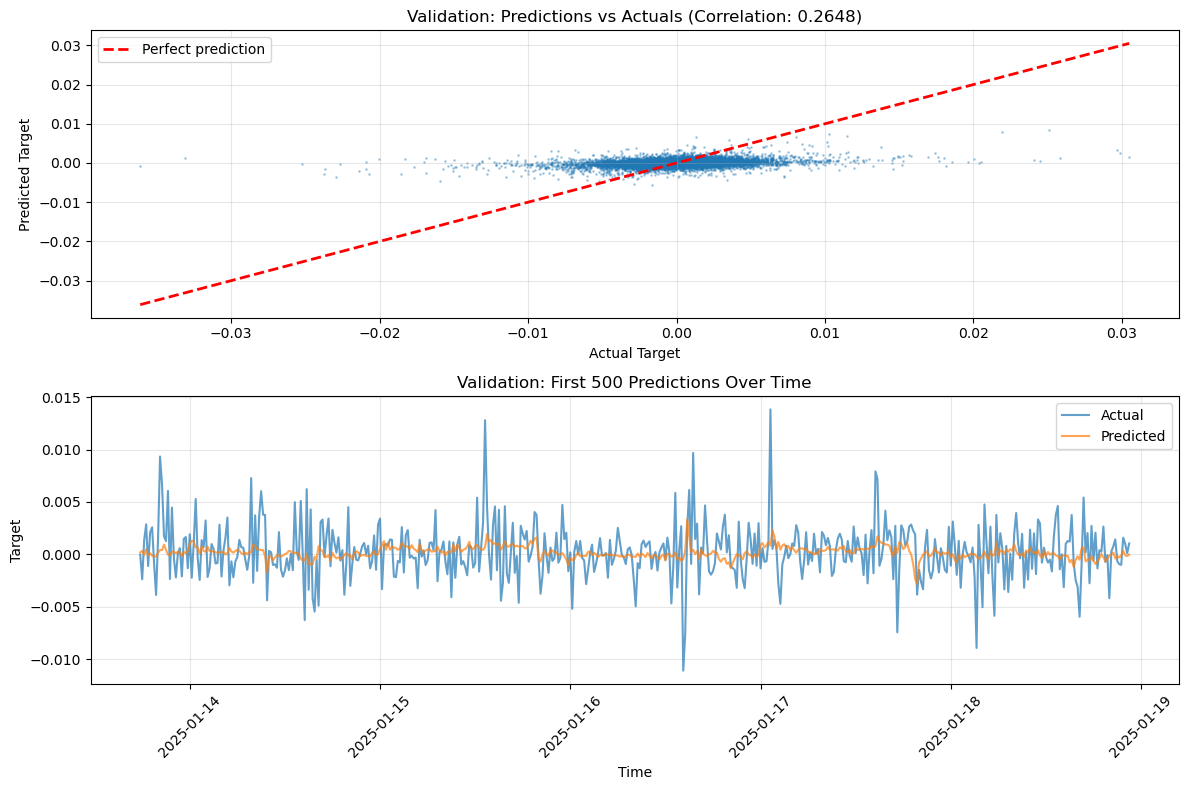

In [19]:
# Visualization: Predictions vs Actuals
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

# Plot 1: Scatter plot
axes[0].scatter(y_val, y_val_pred, alpha=0.3, s=1)
axes[0].plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()],
             'r--', lw=2, label='Perfect prediction')
axes[0].set_xlabel('Actual Target')
axes[0].set_ylabel('Predicted Target')
axes[0].set_title(f'Validation: Predictions vs Actuals (Correlation: {correlation:.4f})')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Time series of predictions
val_timestamps = train_df.iloc[-val_size:]['Timestamp'].values
axes[1].plot(val_timestamps[:500], y_val[:500], label='Actual', alpha=0.7)
axes[1].plot(val_timestamps[:500], y_val_pred[:500], label='Predicted', alpha=0.7)
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Target')
axes[1].set_title('Validation: First 500 Predictions Over Time')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [20]:
# Feature Importance Analysis
importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': lgb_model.feature_importance(importance_type='gain')
}).sort_values('importance', ascending=False)

print("=" * 60)
print("Top 30 Most Important Features")
print("=" * 60)
print(importance.head(30).to_string())

Top 30 Most Important Features
                 feature  importance
490    intraday_position    5.281993
2         high_low_range    0.939875
457                 hour    0.918322
498    range_position_96    0.683193
491      intraday_return    0.442932
83          range_mean_4    0.365927
6                   body    0.331720
441                rs_24    0.304146
4           upper_shadow    0.298928
84           range_std_4    0.288391
515    volume_volatility    0.266996
5           lower_shadow    0.258461
443                rs_96    0.253301
442                rs_48    0.250330
298         rsi_change_4    0.250313
1             log_volume    0.249472
75        returns_kurt_4    0.237011
453  efficiency_ratio_16    0.230498
495    range_position_48    0.228486
66        returns_lag_96    0.226969
69       returns_lag_288    0.220810
74        returns_skew_4    0.220300
395        volume_change    0.209853
237       realized_vol_4    0.204511
55        returns_lag_32    0.202504
333    

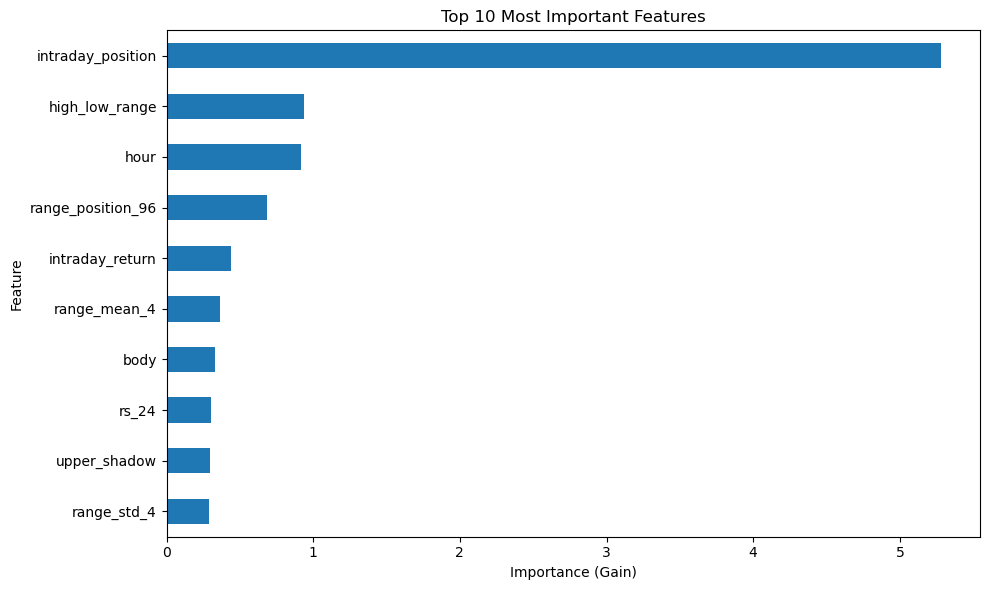

In [21]:
# Plot feature importance
fig, ax = plt.subplots(figsize=(10, 6))
importance.head(10).plot(x='feature', y='importance', kind='barh', ax=ax, legend=False)
ax.set_title('Top 10 Most Important Features')
ax.set_xlabel('Importance (Gain)')
ax.set_ylabel('Feature')
ax.invert_yaxis()
plt.tight_layout()
plt.show()

---
## 7. Generate Submission

Generate predictions for the test set and create the submission file.

In [22]:
# Generate predictions on test set
print("Generating predictions on test set...")
final_predictions = lgb_model.predict(X_test_scaled, num_iteration=lgb_model.best_iteration)

print(f"Generated {len(final_predictions)} predictions")

Generating predictions on test set...
Generated 2881 predictions


In [23]:
# Create submission dataframe
submission = pd.DataFrame({
    'Timestamp': test_df['Timestamp'].dt.strftime('%Y-%m-%d %H:%M:%S'),
    'Prediction': final_predictions
})

# Save submission
submission.to_csv('submission.csv', index=False)

print("=" * 60)
print("Submission Statistics")
print("=" * 60)
print(f"Submission saved to: submission.csv")
print(f"Submission shape: {submission.shape}")
print(f"\nPrediction statistics:")
print(f"  Mean: {final_predictions.mean():.8f}")
print(f"  Std:  {final_predictions.std():.8f}")
print(f"  Min:  {final_predictions.min():.8f}")
print(f"  Max:  {final_predictions.max():.8f}")

Submission Statistics
Submission saved to: submission.csv
Submission shape: (2881, 2)

Prediction statistics:
  Mean: -0.00009513
  Std:  0.00075606
  Min:  -0.00471288
  Max:  0.00605899


In [24]:
# Preview submission
print("\nFirst 5 predictions:")
display(submission.head())

print("\nLast 5 predictions:")
display(submission.tail())


First 5 predictions:


,Timestamp,Prediction
484202,2025-10-23 23:30:00,-0.000161
484203,2025-10-23 23:45:00,-0.000093
484204,2025-10-24 00:00:00,0.000051
484205,2025-10-24 00:15:00,0.000396
484206,2025-10-24 00:30:00,0.000247



Last 5 predictions:


,Timestamp,Prediction
487078,2025-11-22 22:30:00,-0.000101
487079,2025-11-22 22:45:00,-0.000061
487080,2025-11-22 23:00:00,-0.000309
487081,2025-11-22 23:15:00,-0.000169
487082,2025-11-22 23:30:00,0.000055


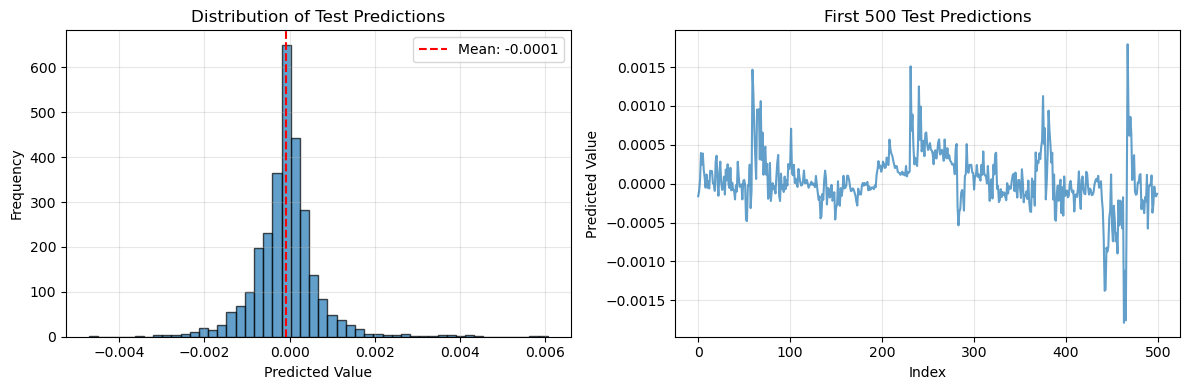

In [25]:
# Plot prediction distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Histogram
axes[0].hist(final_predictions, bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Predicted Value')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Test Predictions')
axes[0].axvline(final_predictions.mean(), color='r', linestyle='--', label=f'Mean: {final_predictions.mean():.4f}')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Time series
axes[1].plot(final_predictions[:500], alpha=0.7)
axes[1].set_xlabel('Index')
axes[1].set_ylabel('Predicted Value')
axes[1].set_title('First 500 Test Predictions')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---
## Summary

This notebook implemented a complete cryptocurrency price prediction pipeline:

1. **Data Loading**: Loaded train and test OHLCV data
2. **Feature Engineering**: Created 500+ features including technical indicators, volatility measures, momentum signals, and time-based features
3. **Preprocessing**: Handled missing values with median imputation and scaled features with RobustScaler
4. **Model Training**: Trained LightGBM with early stopping on time-series validation split
5. **Evaluation**: Measured performance using RMSE and Pearson correlation
6. **Submission**: Generated predictions and saved to submission.csv

### Key Design Decisions:
- Used last 70% of training data (cryptocurrency markets evolve)
- Time-series split prevents data leakage
- RobustScaler handles outliers common in crypto data
- Extensive regularization (feature/bagging fractions, L1/L2) prevents overfitting

In [26]:
print("=" * 60)
print("COMPLETED!")
print("=" * 60)
print(f"\nValidation Correlation: {correlation:.6f}")
print(f"Submission file: submission.csv")

COMPLETED!

Validation Correlation: 0.264806
Submission file: submission.csv
